## Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

## Veri Setinin Yüklenmesi, Düzenlenmesi ve Görselleştirilmesi

In [2]:
## Dataset Dataframe olarak alındı
houses_df = pd.read_csv("/content/dataset_houses_besiktas.csv")
houses_df.head()

,Kira,Alan,Oda Sayısı,Banyo Sayısı,WC Sayısı,Bina Yaşı,Isıtma Tipi,Balkon Durumu,Eşya Durumu,Site İçerisinde
0,4100,80,2+1,1,1,20 Ve Üzeri,Merkezi Doğalgaz,Yok,Boş,Evet
1,3100,80,3+1,1,0,20 Ve Üzeri,Kombi Doğalgaz,Yok,Boş,Hayır
2,15000,210,5+2,1,2,20 Ve Üzeri,Merkezi Doğalgaz,Var,Boş,Hayır
3,3500,110,3+1,1,1,20 Ve Üzeri,Kombi Doğalgaz,Var,Boş,Hayır
4,2900,60,Stüdyo,1,1,5-10,Doğalgaz Sobalı,Yok,Eşyalı,Hayır


In [3]:
## Verinin başarısını olumsuz etkileyecek uç durumlar temizlenerek veri düzenlendi
houses_df = houses_df[houses_df['Kira'] < 10000]
houses_df = houses_df[houses_df['Kira'] > 1000]
houses_df = houses_df.reset_index(drop=True)

In [4]:
print(houses_df['Oda Sayısı'].unique().tolist())
print(houses_df['Bina Yaşı'].unique().tolist())
print(houses_df['Balkon Durumu'].unique().tolist())
print(houses_df['Eşya Durumu'].unique().tolist())
print(houses_df['Site İçerisinde'].unique().tolist())

['2+1', '3+1', 'Stüdyo', '1+1', '3+2', '1 Oda', '5+1', '8+ Oda', '4+1']
['20 Ve Üzeri', '5-10', '11-20', '0 (Yeni)', '1', '4', '3', '2']
['Yok', 'Var']
['Boş', 'Eşyalı']
['Evet', 'Hayır']


In [5]:
## Verideki kategorisel verilerin nümerik değerlere çevrilmesi yapıldı. Bu sayede daha iyi sonuçlar alınması hedeflendi.
oda_hashmap = {'2+1': 4,'3+1': 5,'5+2': 9,'Stüdyo': 1,'1+1': 2,'3+2': 7,'1 Oda': 1,'4+1': 6,'5+1': 7,'4+2': 8,'8+ Oda': 13,'7+2': 11,'6+2': 10}
bina_hashmap = {'20 Ve Üzeri': 25, '5-10': 7, '11-20': 15, '4': 4, '0 (Yeni)': 0, '1': 1, '3': 3, '2': 2}
balkon_hashmap = {'Yok': -1, 'Var': 1}
esya_hashmap = {'Boş': -1, 'Eşyalı': 1}
site_hashmap = {'Evet': 1, 'Hayır': -1}

In [6]:
houses_df = houses_df.replace({'Oda Sayısı': oda_hashmap})
houses_df = houses_df.replace({'Bina Yaşı': bina_hashmap})
houses_df = houses_df.replace({'Balkon Durumu': balkon_hashmap})
houses_df = houses_df.replace({'Eşya Durumu': esya_hashmap})
houses_df = houses_df.replace({'Site İçerisinde': site_hashmap})
houses_df.head()

,Kira,Alan,Oda Sayısı,Banyo Sayısı,WC Sayısı,Bina Yaşı,Isıtma Tipi,Balkon Durumu,Eşya Durumu,Site İçerisinde
0,4100,80,4,1,1,25,Merkezi Doğalgaz,-1,-1,1
1,3100,80,5,1,0,25,Kombi Doğalgaz,-1,-1,-1
2,3500,110,5,1,1,25,Kombi Doğalgaz,1,-1,-1
3,2900,60,1,1,1,7,Doğalgaz Sobalı,-1,1,-1
4,2500,120,5,1,1,7,Merkezi Doğalgaz,-1,1,-1


In [7]:
## Nümerik olarak ifade edilemeyen "Isıtma Tipi" sınıfı dummy coding ile ifade edildi
houses_df = pd.get_dummies(houses_df)

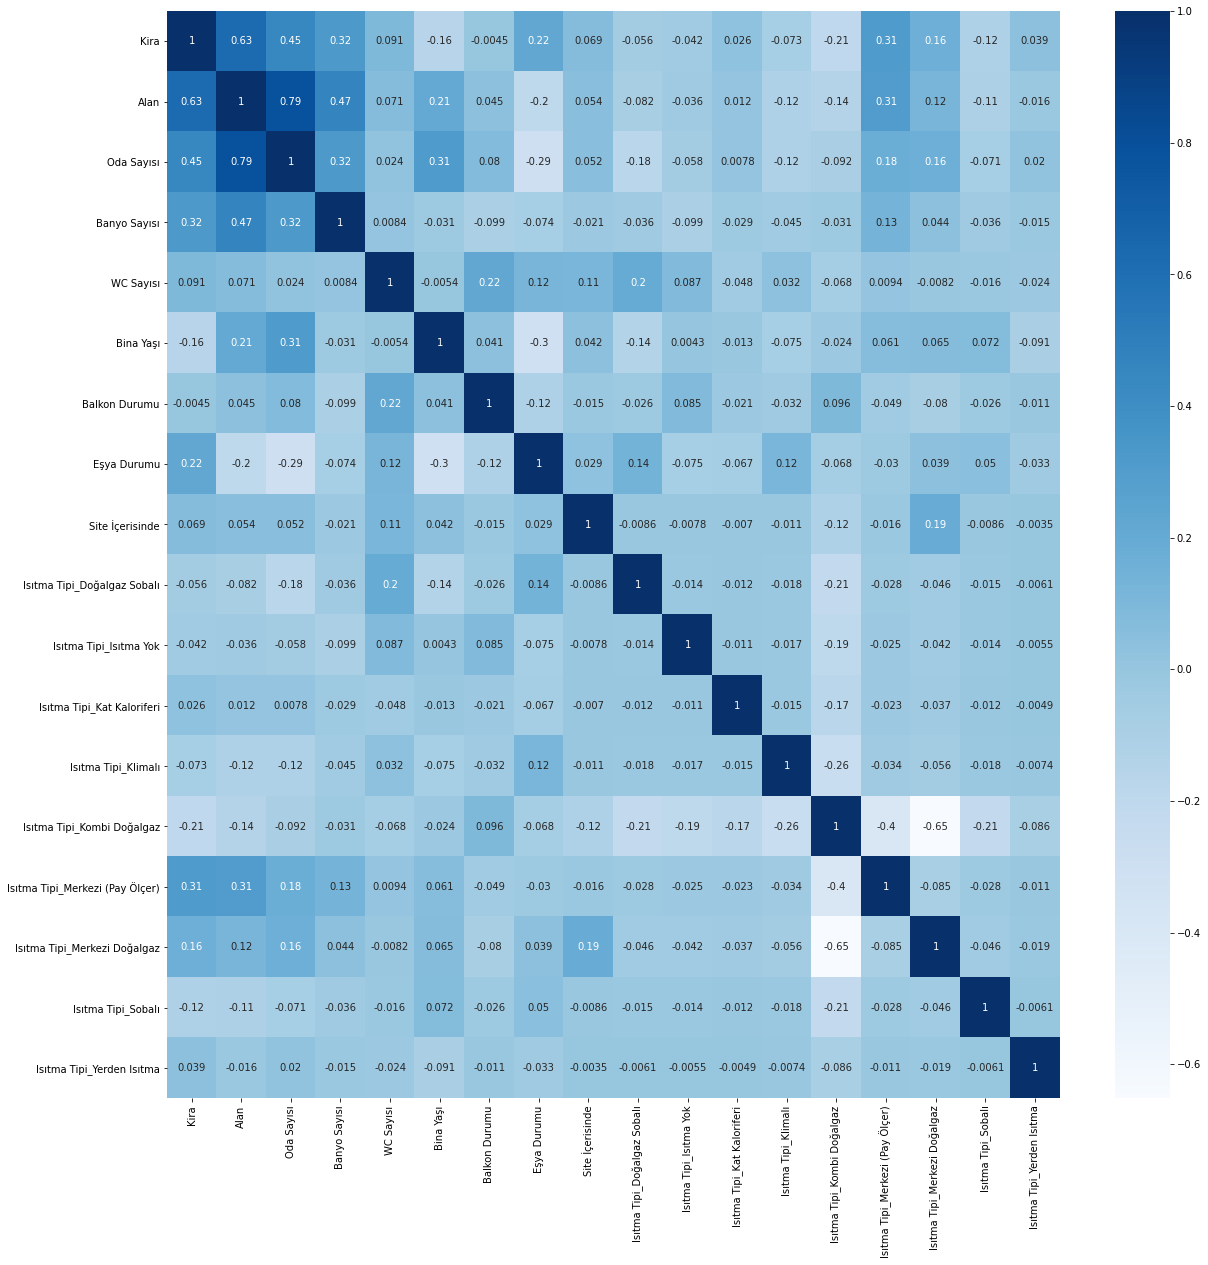

In [8]:
## Hangi özelliklerin birbiriyle ne kadar korelasyonu olduğunu gösteren grafik

plt.figure(figsize=(20, 20))
sns.heatmap(houses_df.corr(), annot=True, cmap="Blues")
plt.show()

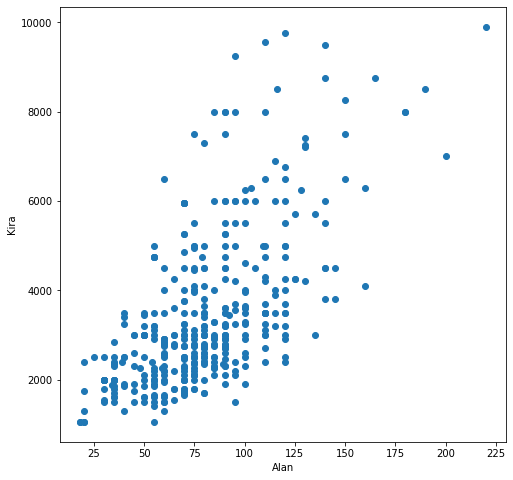

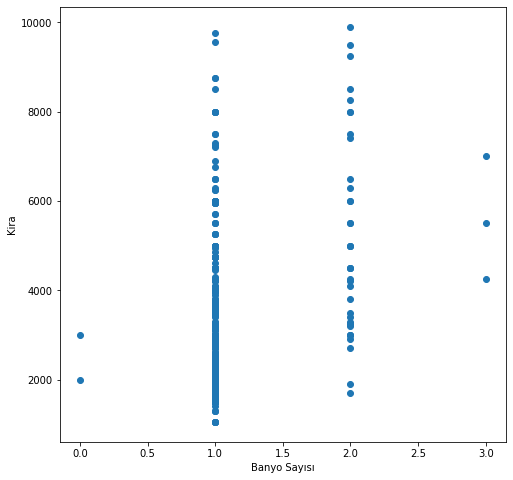

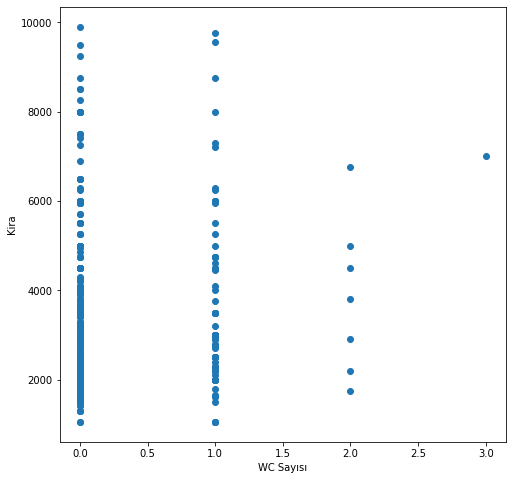

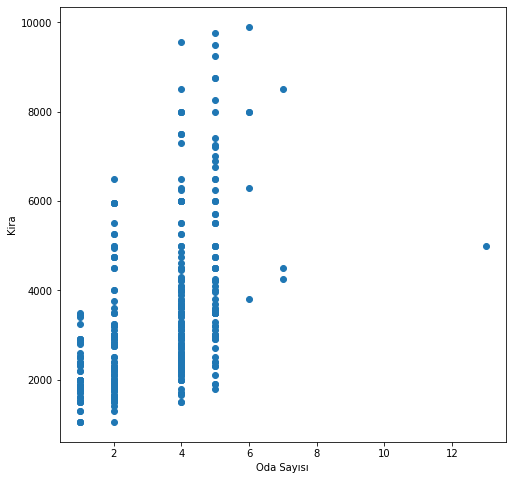

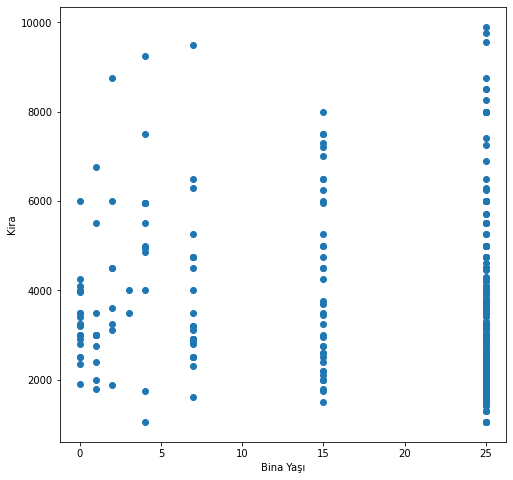

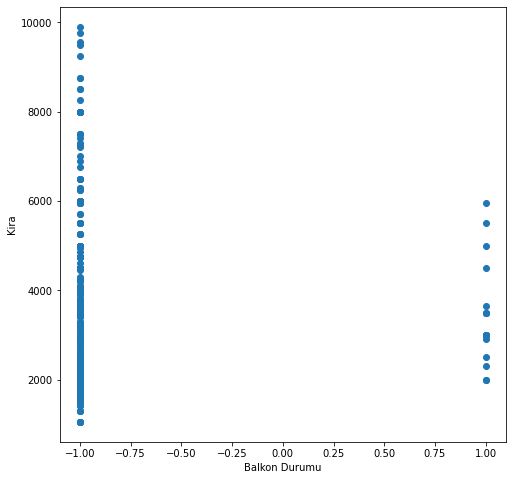

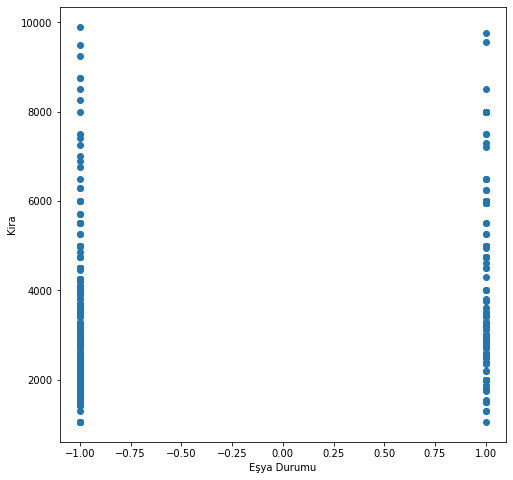

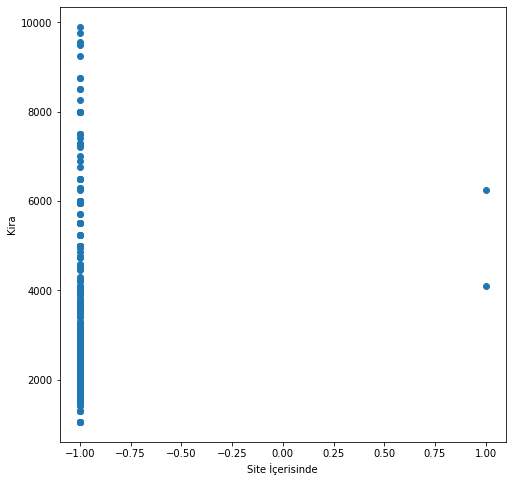

In [9]:
## Tüm kategorilerin "Kira" kategorisine karşı grafikleri çizdirildi
plot_columns = ['Alan', 'Banyo Sayısı', 'WC Sayısı', 'Oda Sayısı', 'Bina Yaşı', 'Balkon Durumu', 'Eşya Durumu', 'Site İçerisinde']
for i in plot_columns:
  plt.figure(figsize=(8,8))
  plt.scatter(houses_df[i], houses_df['Kira'])
  plt.xlabel(i)
  plt.ylabel('Kira')

## Veri Setinin Eğitim ve Test Seti Olarak Ayrılması

In [10]:
## Veri test ve train olmak üzere 2 parçaya ayrıldı
houses_df_train, houses_df_test = train_test_split(houses_df, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 10)

In [11]:
X_train = houses_df_train ## Kira harici kategoriler
y_train = X_train.pop('Kira') ## Kira kategorisi
X_test = houses_df_test
y_test = X_test.pop('Kira')

In [12]:
X_train.head()

,Alan,Oda Sayısı,Banyo Sayısı,WC Sayısı,Bina Yaşı,Balkon Durumu,Eşya Durumu,Site İçerisinde,Isıtma Tipi_Doğalgaz Sobalı,Isıtma Tipi_Isıtma Yok,Isıtma Tipi_Kat Kaloriferi,Isıtma Tipi_Klimalı,Isıtma Tipi_Kombi Doğalgaz,Isıtma Tipi_Merkezi (Pay Ölçer),Isıtma Tipi_Merkezi Doğalgaz,Isıtma Tipi_Sobalı,Isıtma Tipi_Yerden Isıtma
64,85,4,1,0,15,-1,-1,-1,0,0,0,0,1,0,0,0,0
27,90,4,1,0,25,-1,-1,-1,0,0,0,0,1,0,0,0,0
280,90,4,1,0,25,-1,-1,-1,0,0,0,0,0,0,1,0,0
88,75,4,1,0,25,-1,-1,-1,0,0,0,0,1,0,0,0,0
109,90,5,2,0,7,-1,-1,-1,0,0,0,0,1,0,0,0,0


In [13]:
y_train

64     2950
27     2750
280    2100
88     2800
109    4500
       ... 
369    1800
320    2000
15     7400
125    2900
265    8250
Name: Kira, Length: 326, dtype: int64

## Farklı Tahminleyicilerle Deneme ve Normalizasyon

In [14]:
## Verilen DataFrame üzerinde MinMax normalizasyonu yapan fonksiyon
def normalize(df):
  scaler = MinMaxScaler()
  df_normalize = scaler.fit_transform(df)
  df_normalize = pd.DataFrame(df_normalize, columns=df.columns)
  return df_normalize

In [15]:
## Verilen bir estimator (tahminleyici) ve normalizasyon parametresi kullanılarak başarı oranı hesaplayan ve çizdiren fonksiyon
def get_estimator_results(estimator_array, norm=False):
  reg_model_1 = LinearRegression()
  if norm:
    X_train_normalize = normalize(X_train)
    X_train_1 = X_train_normalize[estimator_array]
  else:
    X_train_1 = X_train[estimator_array]
  X_train_1.head()

  scores_1 = cross_val_score(reg_model_1, X_train_1, y_train, scoring='r2', cv=10)
  reg_model_1.fit(X_train_1, y_train)

  plt.figure(figsize=(16,8))

  for i in estimator_array:
      plt.scatter(X_train_1[i], y_train, color=np.random.rand(3,))

  array = reg_model_1.predict(X_train_1)
  plt.plot(X_train_1, array, color="red")
  print(type(X_train_1))
  norm = " (Normalizasyon Var)" if norm == True else " (Normalizasyon Yok)"
  plt.title("Ortalama Başarı Oranı: " + str(scores_1.mean()) + norm)
  plt.xlabel(estimator_array)
  plt.ylabel('Kira')

In [16]:
## Verilen bir estimator (tahminleyici) ve normalizasyon parametresi kullanılarak başarı oranı hesaplayan ve çizdiren fonksiyon
def get_estimator_results(estimator_array, norm=False):
  reg_model_1 = LinearRegression()
  if norm:
    X_train_normalize = normalize(X_train)
    X_train_1 = X_train_normalize[estimator_array]
  else:
    X_train_1 = X_train[estimator_array]

  # 10 katlı çapraz geçerleme sonuçlarının elde edilmesi
  scores_1 = cross_val_score(reg_model_1, X_train_1, y_train, scoring='r2', cv=10)
  reg_model_1.fit(X_train_1, y_train)

  plt.figure(figsize=(16,8))

  for i in estimator_array:
      color_ = np.random.rand(3,)
      plt.scatter(X_train_1[i], y_train, color=color_)
      reg_model = LinearRegression()
      reg_model.fit(pd.DataFrame(X_train_1[i]), y_train)
      array = reg_model.predict(pd.DataFrame(X_train_1[i]))
      plt.plot(X_train_1[i], array, color=color_)

  array = reg_model_1.predict(X_train_1)
  # plt.plot(X_train_1, array, color="red")
  norm = " (Normalizasyon Var)" if norm == True else " (Normalizasyon Yok)"
  plt.title("Ortalama Başarı Oranı: " + str(scores_1.mean()) + norm)
  plt.xlabel(estimator_array)
  plt.ylabel('Kira')

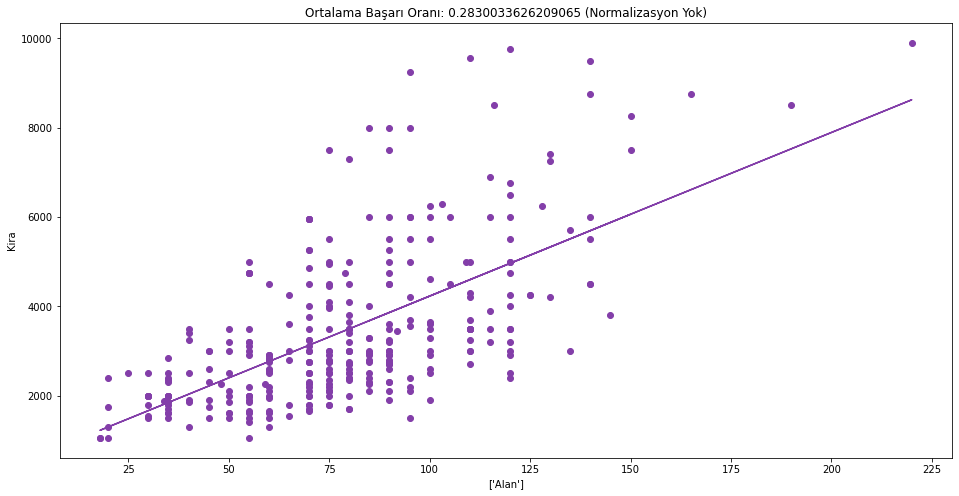

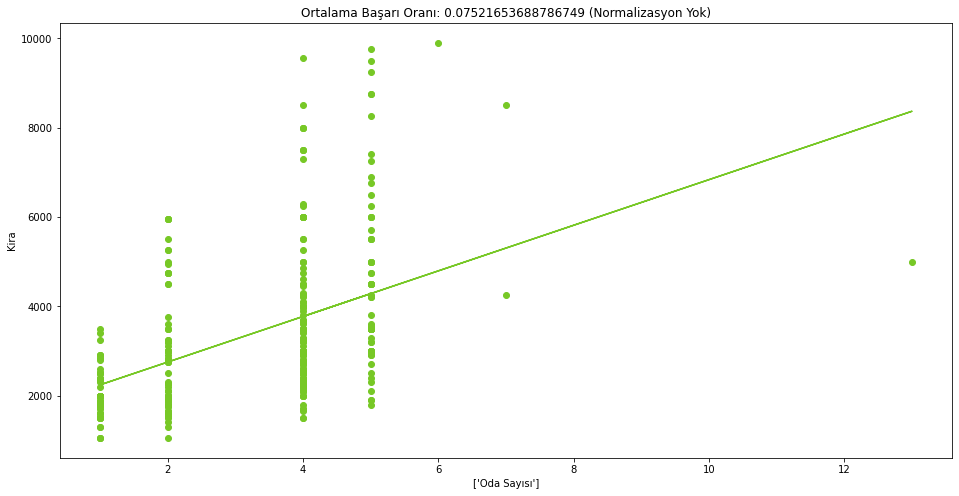

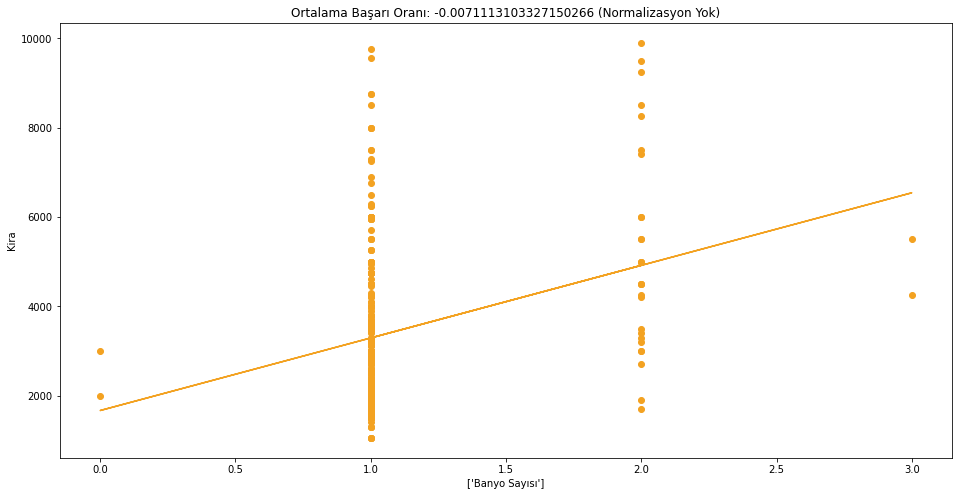

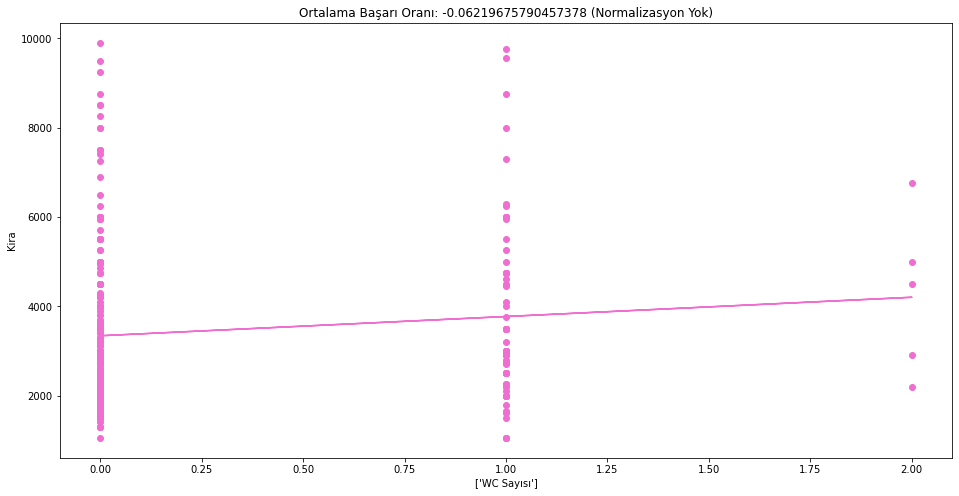

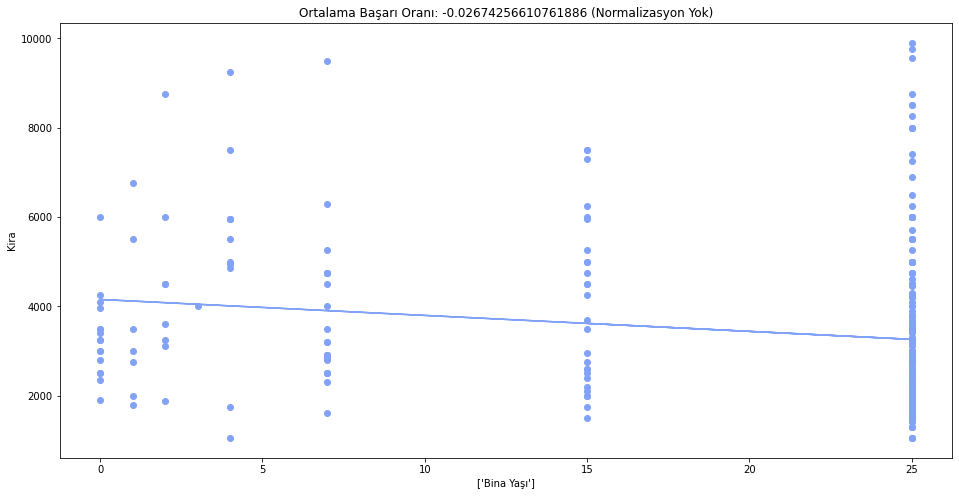

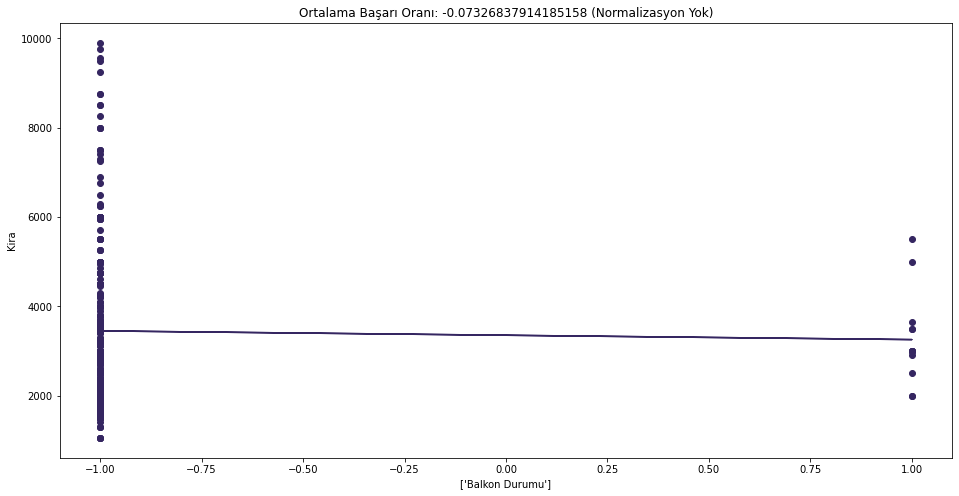

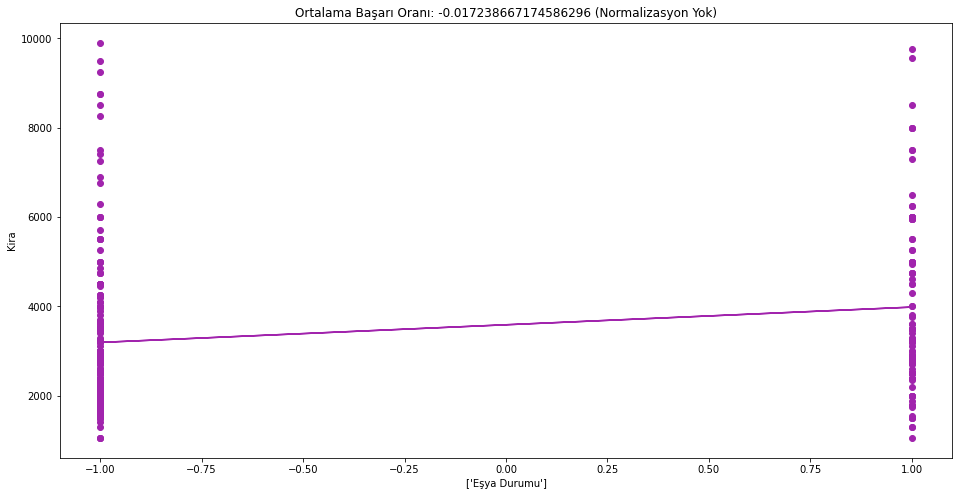

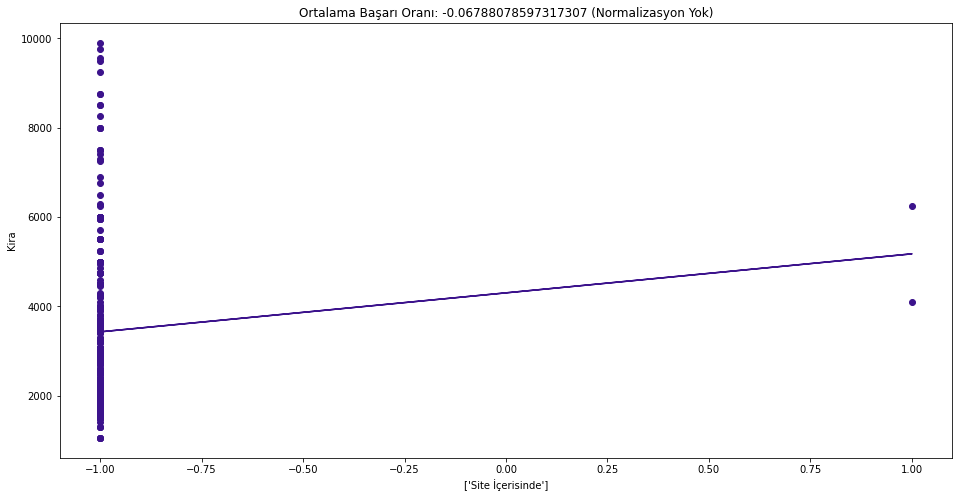

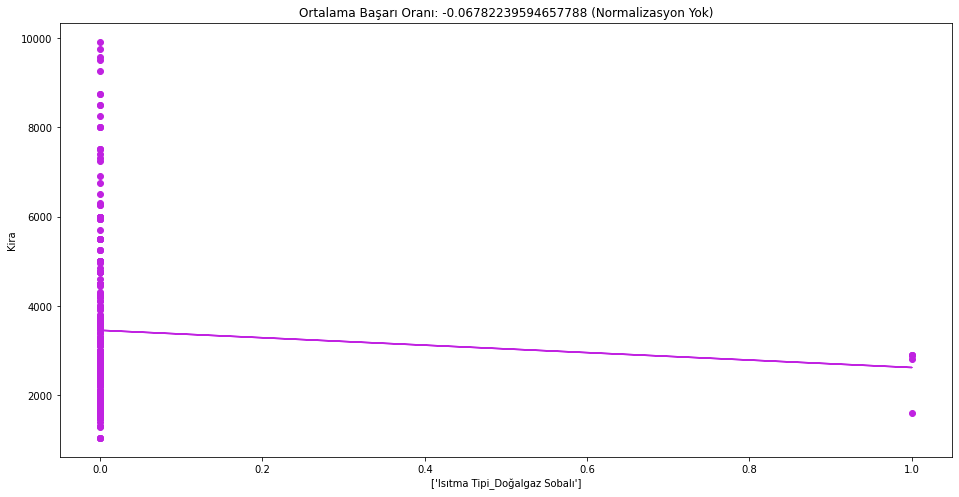

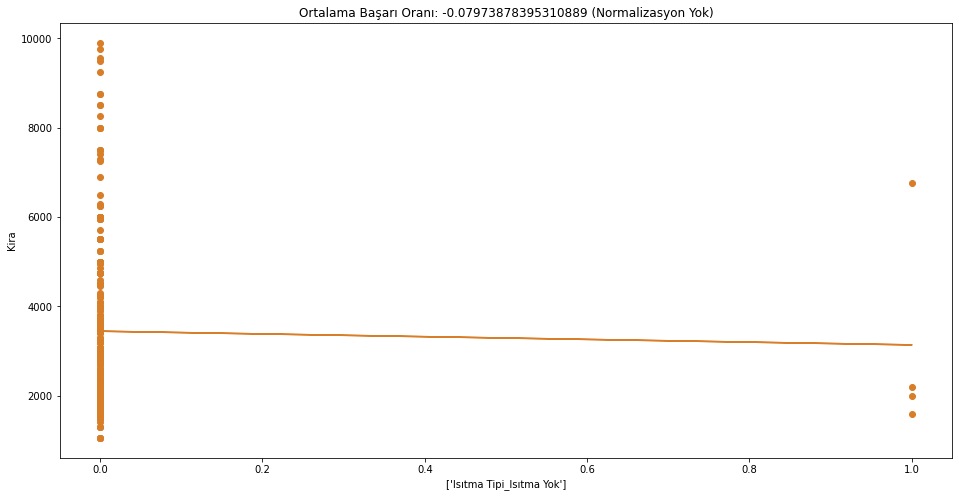

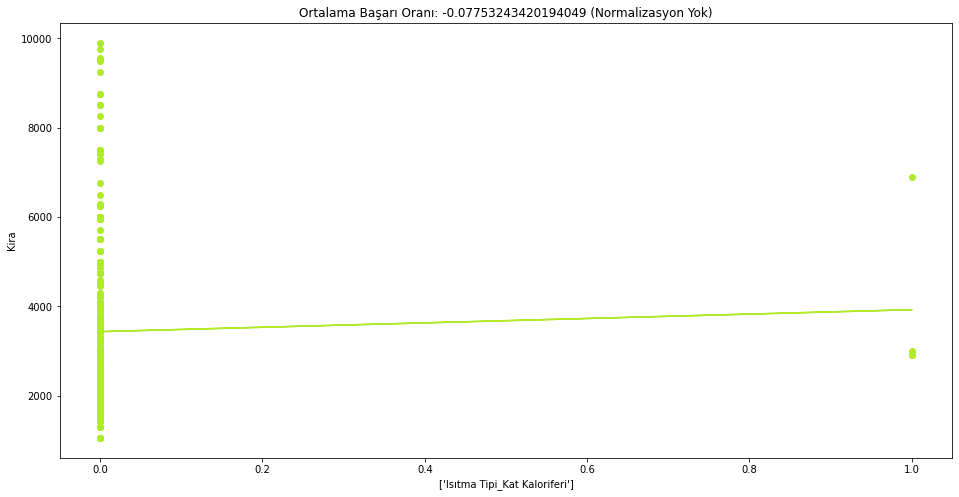

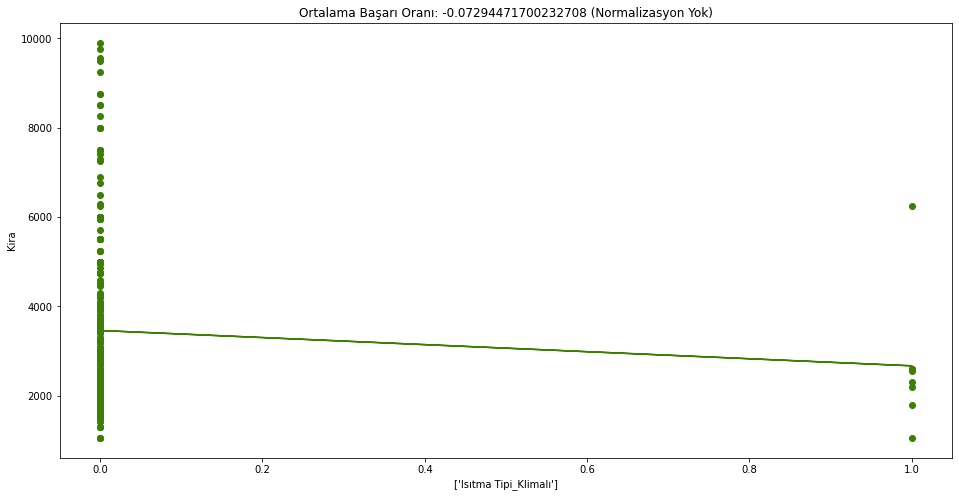

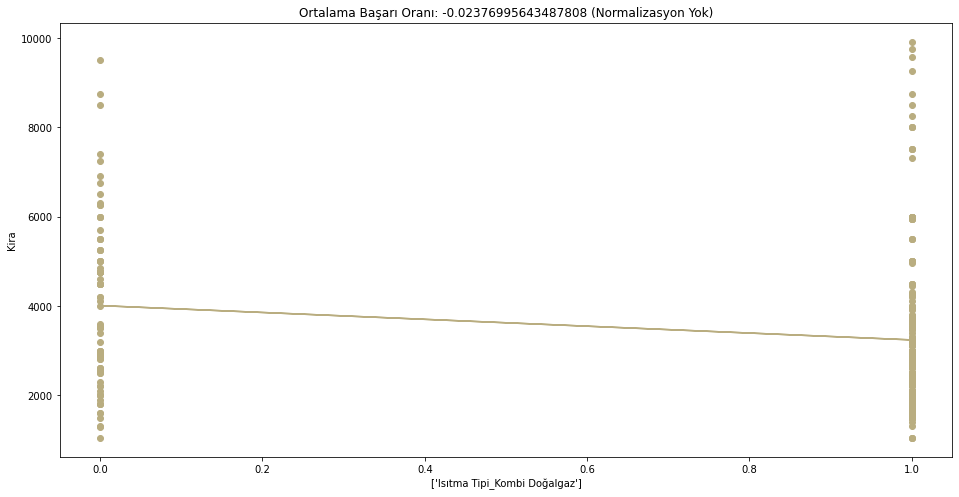

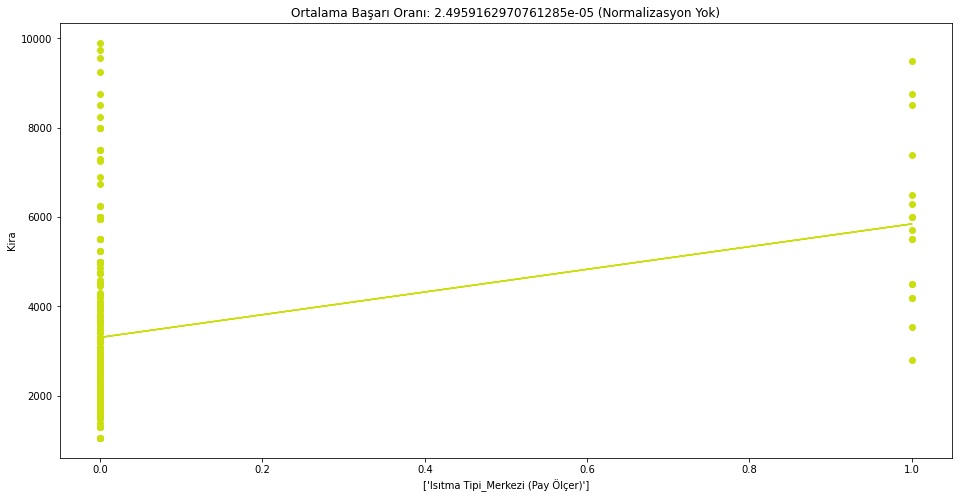

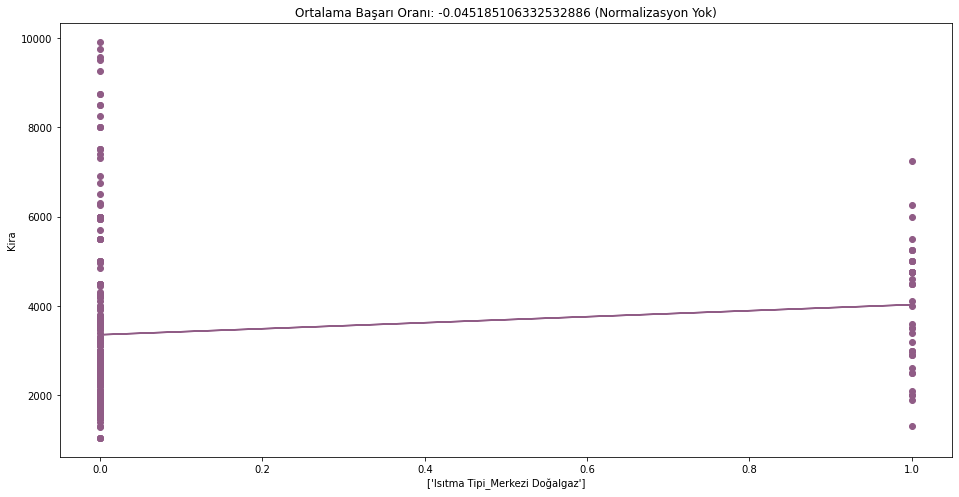

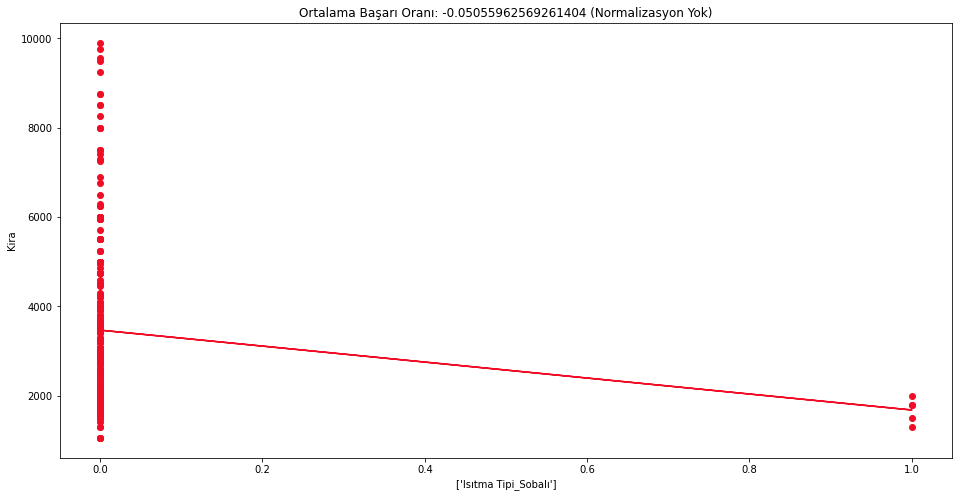

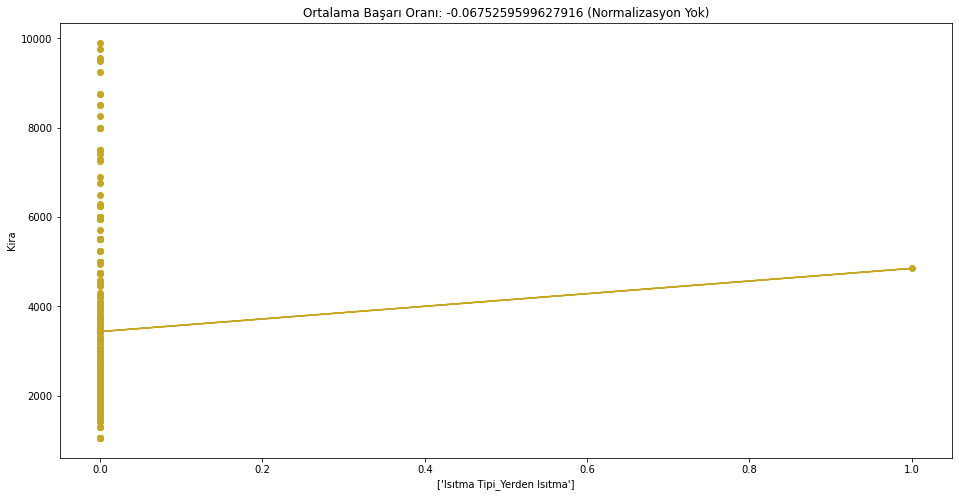

In [17]:
## Bütün özelliklere göre tahminleyici sonuçlarının çizilmesi
for i in X_train.columns:
  get_estimator_results([i])

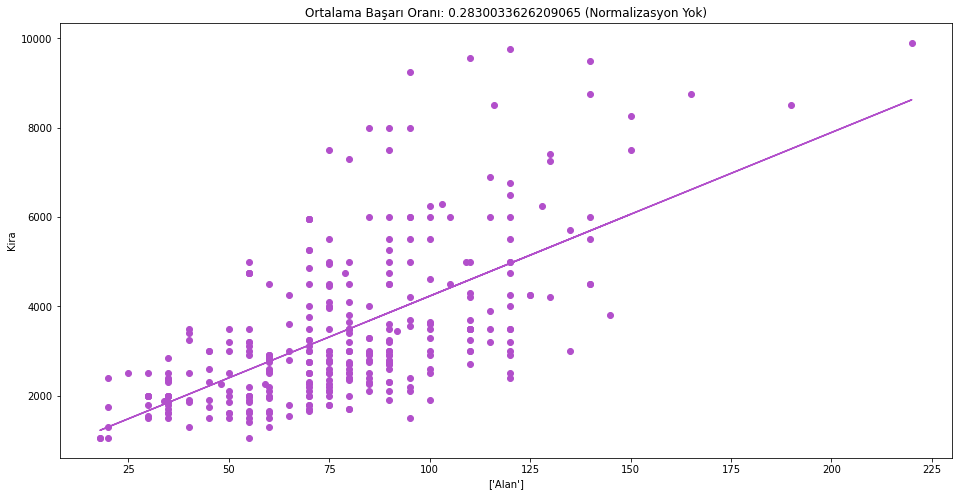

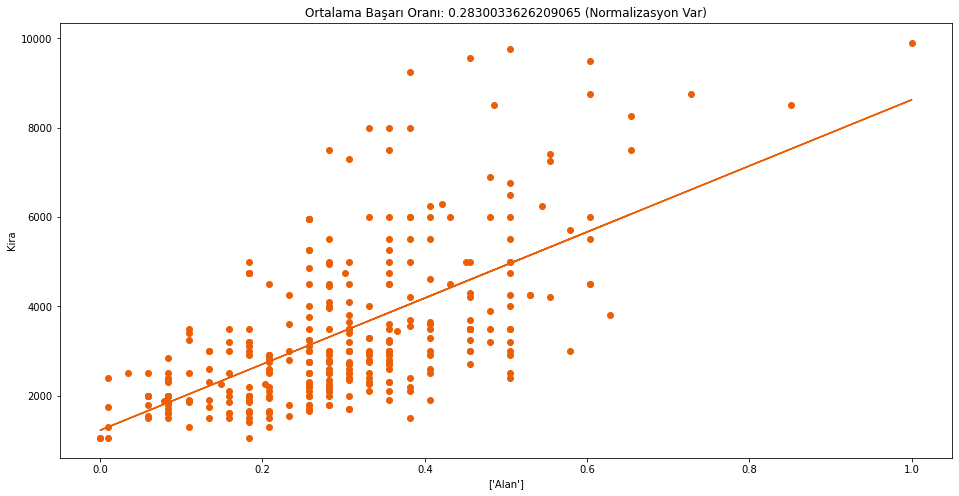

In [18]:
## 1 numaralı tahminleyici
get_estimator_results(['Alan'])             # Normalizasyon yokken
get_estimator_results(['Alan'], norm=True)  # Normalizasyon varken

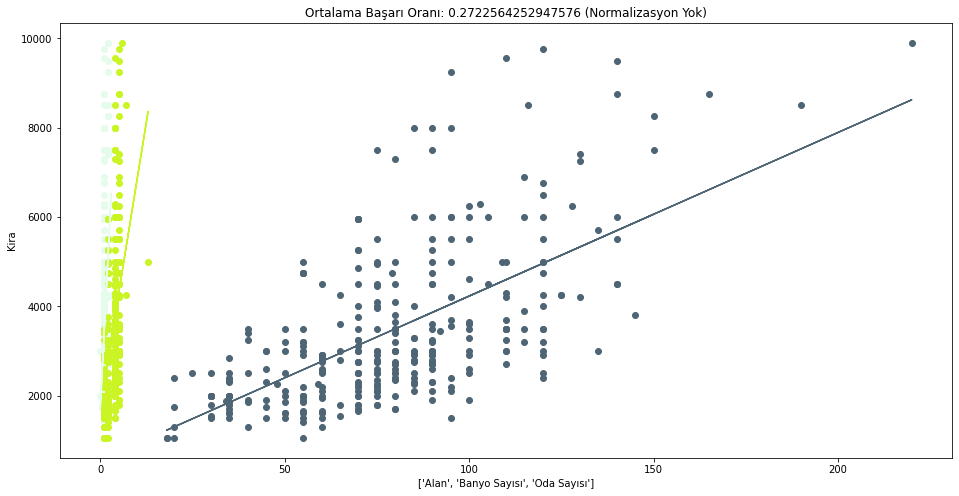

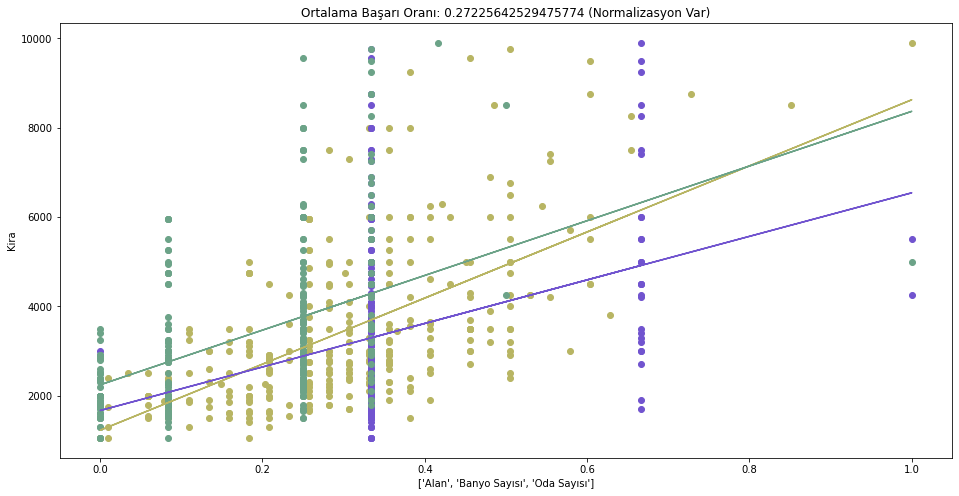

In [19]:
## 2 numaralı tahminleyici
estimator_array = ['Alan', 'Banyo Sayısı', 'Oda Sayısı']
get_estimator_results(estimator_array)
get_estimator_results(estimator_array, norm=True)

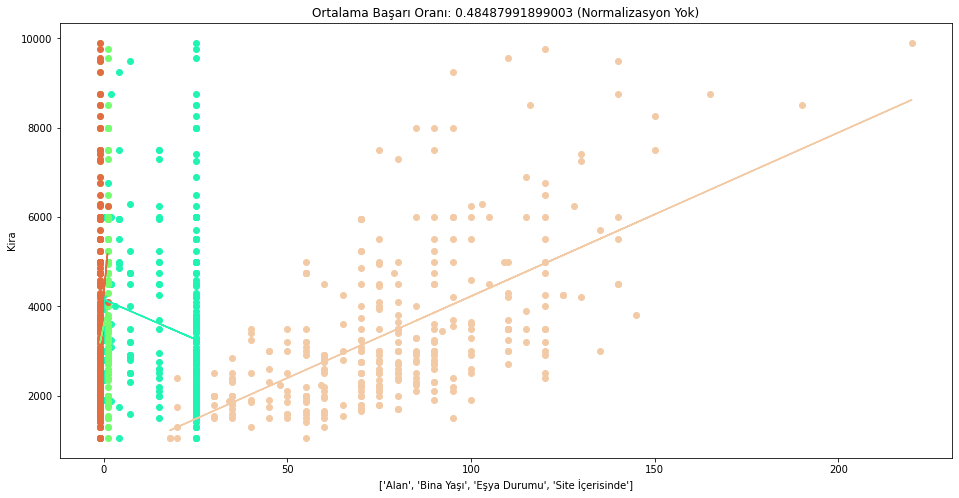

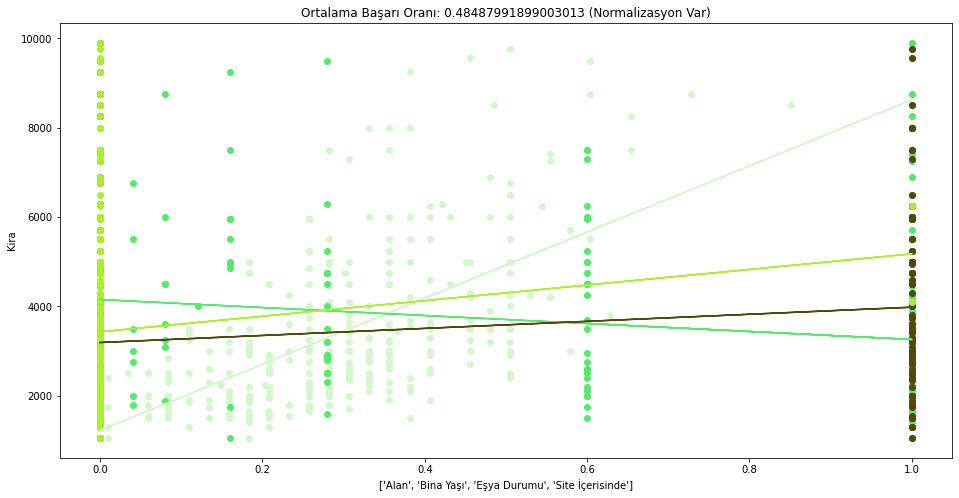

In [20]:
## 3 numaralı tahminleyici
estimator_array = ['Alan', 'Bina Yaşı', 'Eşya Durumu', 'Site İçerisinde']
get_estimator_results(estimator_array)
get_estimator_results(estimator_array, norm=True)

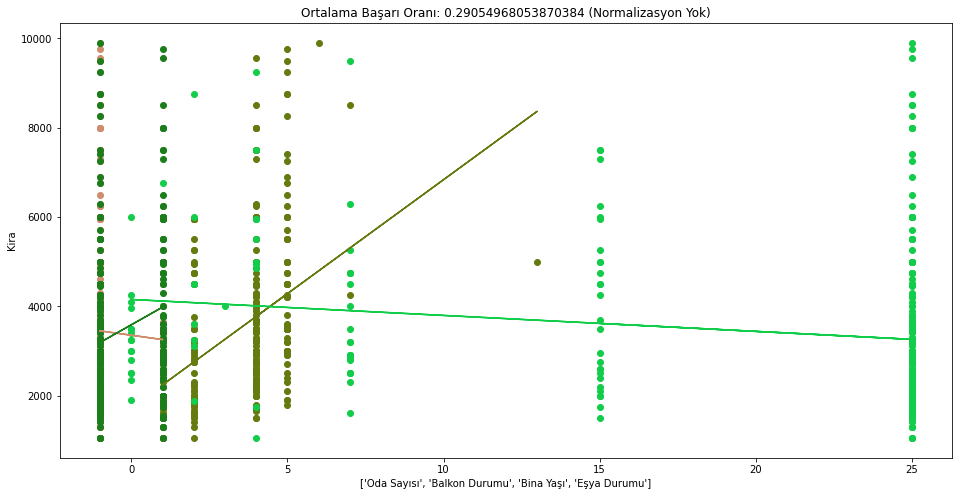

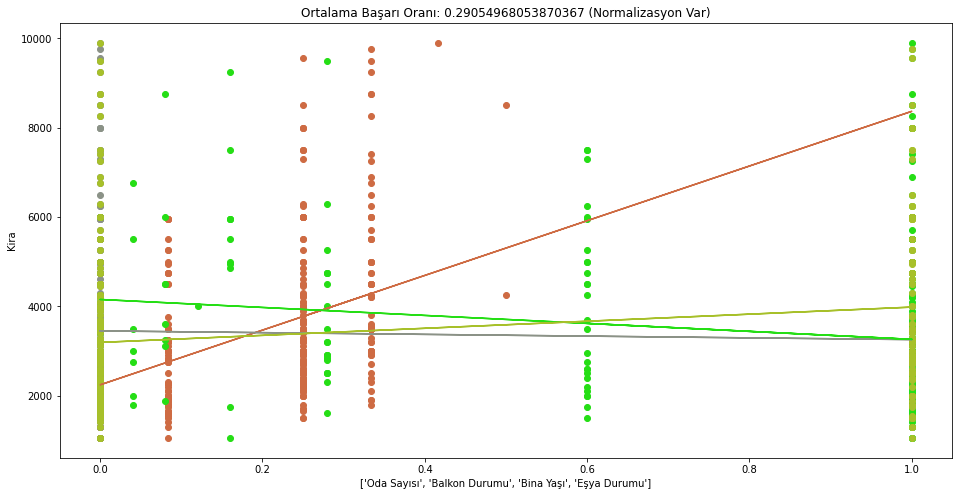

In [21]:
## 4 numaralı tahminleyici
estimator_array = ['Oda Sayısı', 'Balkon Durumu', 'Bina Yaşı', 'Eşya Durumu']
get_estimator_results(estimator_array)
get_estimator_results(estimator_array, norm=True)

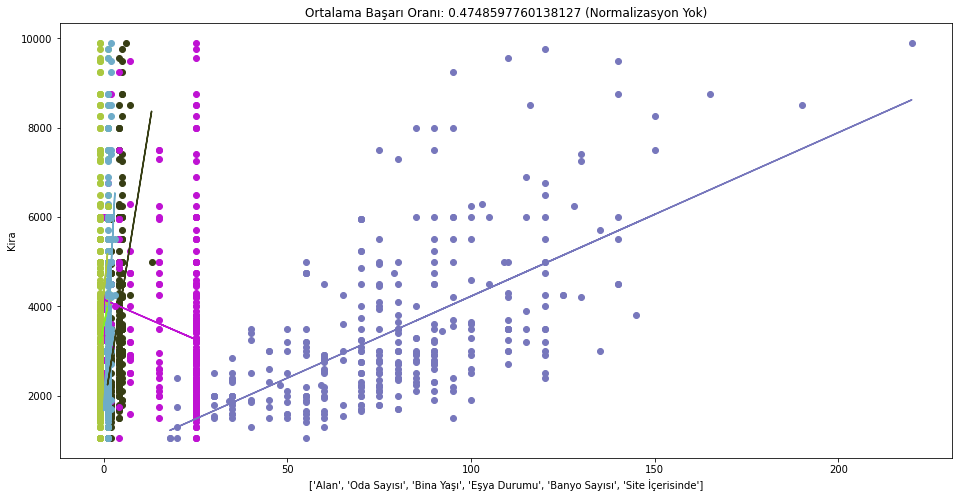

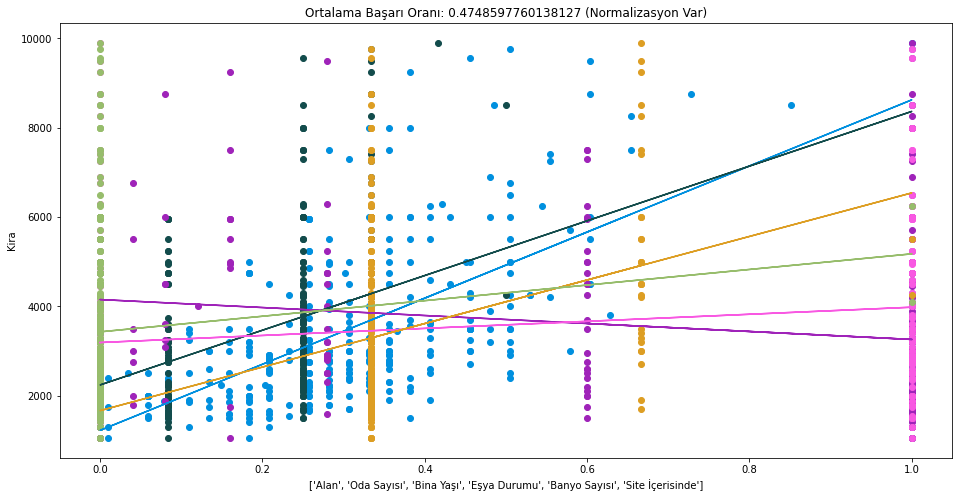

In [22]:
## 5 numaralı tahminleyici
estimator_array = ['Alan', 'Oda Sayısı', 'Bina Yaşı', 'Eşya Durumu', 'Banyo Sayısı', 'Site İçerisinde']
get_estimator_results(estimator_array)
get_estimator_results(estimator_array, norm=True)

## Özellik Seçimi

In [23]:
## Lineer regresyon modeli oluşturulup fit edildi
regression = LinearRegression()
reg_model = regression.fit(X_train, y_train)

In [24]:
## Verilen veri seti ve kaç feature seçilmesi gerektiği bilgisiyle Özellik Seçimi yapan fonksiyon
def feature_selection(X, Y, features_to_select):
    final_model = RFE(reg_model, n_features_to_select=features_to_select)
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X)
    final_score = sklearn.metrics.r2_score(Y, y_pred)
    return final_score

In [25]:
## Özellik Seçimleri sonucunda özellik sayısı - başarı grafiğinin çizilmesi
test_scores = []
train_scores = []
number_of_features = len(X_train.columns)

for features in range(1, number_of_features):
    test_scores.append(feature_selection(X_test, y_test, features))
    train_scores.append(feature_selection(X_train, y_train, features))

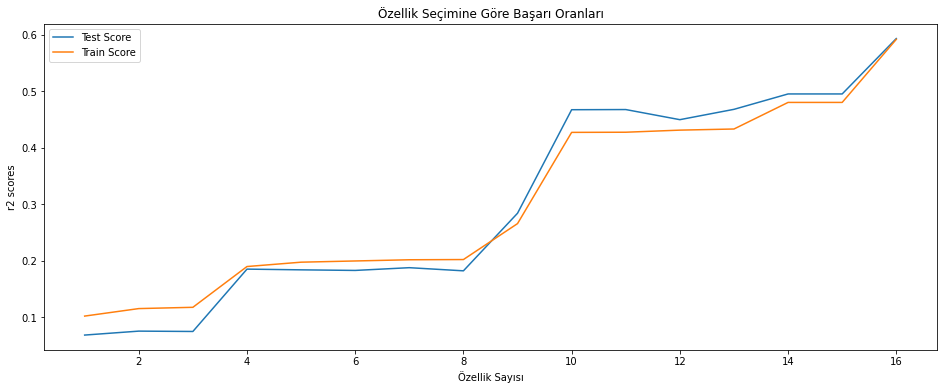

In [26]:
plt.figure(figsize=(16,6))

plt.plot(range(1, number_of_features), test_scores)
plt.plot(range(1, number_of_features), train_scores)
plt.xlabel('Özellik Sayısı')
plt.ylabel('r2 scores')
plt.title("Özellik Seçimine Göre Başarı Oranları")
plt.legend(['Test Score', 'Train Score'])

In [27]:
## Grafiğe göre en uygun sayı 16 yani tüm özellikleri kullanmak olarak görülmektedir.
final_model = RFE(reg_model, n_features_to_select = 16)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
final_score = sklearn.metrics.r2_score(y_test, y_pred)
final_score

0.5936235598384025

## Özellik Dönüşümü

In [28]:
## Verilen komponent sayısına göre PCA ile özellik dönüşümü yapan fonksiyon
def PCA_SCORE(component):
    scaler = StandardScaler()
    houses_df_Normal = scaler.fit_transform(houses_df)

    houses_df_Normal = pd.DataFrame(houses_df_Normal, columns=houses_df.columns)

    pca = PCA(n_components=component)
    houses_df_X = pca.fit_transform(houses_df_Normal[X_train.columns])
    houses_df_X = pd.DataFrame(houses_df_X)

    houses_df_PCA = pd.concat([houses_df_X, houses_df[['Kira']]], axis=1)

    houses_df_PCA_train, houses_df_PCA_test = train_test_split(houses_df_PCA, 
                                      train_size = 0.8, 
                                      test_size = 0.2, 
                                      random_state = 10)

    X_train_PCA = houses_df_PCA_train[range(component)]
    y_train_PCA = houses_df_PCA_train['Kira']

    X_test_PCA = houses_df_PCA_test[range(component)]
    y_test_PCA = houses_df_PCA_test['Kira']

    regression = LinearRegression()
    reg_model = regression.fit(X_train_PCA, y_train_PCA)

    y_pred_PCA_test = reg_model.predict(X_test_PCA)
    y_pred_PCA_train = reg_model.predict(X_train_PCA)

    final_score_test = sklearn.metrics.r2_score(y_test_PCA, y_pred_PCA_test)
    final_score_train = sklearn.metrics.r2_score(y_train_PCA, y_pred_PCA_train)
    return final_score_test, final_score_train



In [29]:
## Komponent sayısı - başarı oranı grafiğinin çizilmesi
scores_train = []
scores_test = []

for component in range(1, number_of_features):
    test_score, train_score = PCA_SCORE(component)
    scores_train.append(train_score)
    scores_test.append(test_score)

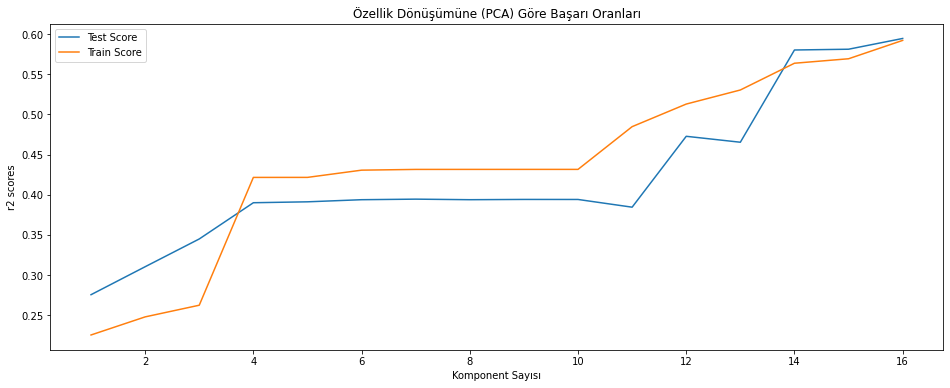

In [30]:
plt.figure(figsize=(16,6))

plt.plot(range(1, number_of_features), scores_test)
plt.plot(range(1, number_of_features), scores_train)
plt.xlabel('Komponent Sayısı')
plt.ylabel('r2 scores')
plt.title('Özellik Dönüşümüne (PCA) Göre Başarı Oranları')
plt.legend(['Test Score', 'Train Score'], loc='upper left') 